In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, median_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import median_absolute_error

In [2]:
df_modelo = pd.read_csv('df_eda_limpio.csv')
df_modelo.head()

,make,model,version,fuel,year,kms,power,shift,price,dealer_name,...,province,vehicle_age,price_per_power,price_per_year,dealer_info,power_per_kms,make_popularity,model_popularity,big_city_dealer,price_range
0,Opel,Crossland,1.2 GAS 110 GS Line 5p S/S,Gasolina,2022,5.0,110.0,manual,22900,Sergio Y.,...,Barcelona,3,208.19,7633.34,"Sergio Y.\r\n2, Carrer de Jacint Benavente, Po...",22.000000,4591,158,0,20-30k
1,Opel,Crossland,1.2 81kW (110CV) GS Line,Gasolina,2022,24847.0,110.0,manual,19990,Peugeot Alcala 534,...,Madrid,3,181.73,6663.34,"Peugeot Alcala 534\r\nAvenida de José Gárate, ...",0.004427,4591,158,0,10-20k
2,Opel,Crossland,1.5D 88kW (120CV) Business Elegance Auto,Diésel,2021,41356.0,120.0,automatic,18590,Clicars S.,...,Madrid,4,154.92,4647.50,"Clicars S.\r\nSan Cristóbal, Avenida de Andalu...",0.002902,4591,158,1,10-20k
3,Opel,Crossland,GS-Line 1.2 GAS MT6 S/S 110cv,Gasolina,2022,11.0,110.0,manual,22700,Vallescar S.,...,Barcelona,3,206.37,7566.67,"Vallescar S.\r\nParc de Bombers de Sabadell, 5...",10.000000,4591,158,0,20-30k
4,Opel,Crossland,GS-Line 1.2 GAS MT6 S/S 110cv,Gasolina,2022,11.0,110.0,manual,22700,Vallescar Ocasion M.,...,Barcelona,3,206.37,7566.67,"Vallescar Ocasion M.\r\n27, Carrer de Fèlix Fe...",10.000000,4591,158,0,20-30k


In [3]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91040 entries, 0 to 91039
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   make              91040 non-null  object 
 1   model             91040 non-null  object 
 2   version           91040 non-null  object 
 3   fuel              91040 non-null  object 
 4   year              91040 non-null  int64  
 5   kms               91040 non-null  float64
 6   power             91040 non-null  float64
 7   shift             91040 non-null  object 
 8   price             91040 non-null  int64  
 9   dealer_name       91040 non-null  object 
 10  dealer_address    91040 non-null  object 
 11  dealer_city       91040 non-null  object 
 12  dealer_zip_code   91040 non-null  int64  
 13  province          91040 non-null  object 
 14  vehicle_age       91040 non-null  int64  
 15  price_per_power   91040 non-null  float64
 16  price_per_year    91040 non-null  float6

In [4]:
# Selección de características relevantes
features = ['year', 'kms', 'power', 'vehicle_age', 'fuel', 'shift', 'make', 'model']
target = 'price'

X = df_modelo[features]
y = df_modelo[target]

In [5]:
# Preprocesamiento de los datos
numeric_features = ['year', 'kms', 'power', 'vehicle_age']
categorical_features = ['fuel', 'shift', 'make', 'model']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [6]:
# Se divide el dataset en conjunto de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Entrenamiento del modelo KNN
knn = KNeighborsRegressor()

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', knn)
])

# Búsqueda de hiperparámetros (ajuste del número de vecinos)
param_grid = {'model__n_neighbors': [3, 5, 7, 9, 11]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

In [8]:
y_pred = best_model.predict(X_test)

# Calcular RMSE y MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Calcular MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)

# Calcular R²
r2 = r2_score(y_test, y_pred)

# Calcular métricas adicionales
medae = median_absolute_error(y_test, y_pred)
r2_adj = 1 - (1 - r2_score(y_test, y_pred)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)


# Mostrar los resultados
print(f'Best K: {grid_search.best_params_}')
print(f'RMSE: {rmse} €')
print(f'MAE: {mae} €')
print(f'MAPE: {mape} %')
print(f'R²: {r2} %')
print(f'R² Ajustado: {r2_adj:.4f} %')

Best K: {'model__n_neighbors': 3}
RMSE: 1819.8399254003727 €
MAE: 444.6970928529584 €
MAPE: 0.49309685837241596 %
R²: 0.9615900037291677 %
R² Ajustado: 0.9616 %


In [9]:
# Ajustar más hiperparámetros en el modelo KNN
param_grid = {
    'model__n_neighbors': [3, 5, 7, 9, 11, 15],
    'model__p': [1, 2]  # p=1 (Manhattan) o p=2 (Euclidiana)
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [10]:
# Evaluar el nuevo modelo
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Calcular MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)

# Calcular R²
r2 = r2_score(y_test, y_pred)

# Mostrar los resultados
print(f'Best K: {grid_search.best_params_}')
print(f'RMSE: {rmse} €')
print(f'MAE: {mae} €')
print(f'MAPE: {mape}%')
print(f'R²: {r2}')

Best K: {'model__n_neighbors': 3, 'model__p': 1}
RMSE: 1800.1565970347915 €
MAE: 440.3260837727006 €
MAPE: 0.48772600040724456%
R²: 0.9624163928256781


In [11]:
# Modelo de RandomForest
rf = RandomForestRegressor(n_estimators=100, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'kms', 'power',
                                                   'vehicle_age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['fuel', 'shift', 'make',
                                                   'model'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [12]:
# Evaluar el modelo
y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Calcular MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)

# Calcular R²
r2 = r2_score(y_test, y_pred)

# Mostrar los resultados
print(f'Best K: {grid_search.best_params_}')
print(f'RMSE: {rmse} €')
print(f'MAE: {mae} €')
print(f'MAPE: {mape} %')
print(f'R²: {r2}')

Best K: {'model__n_neighbors': 3, 'model__p': 1}
RMSE: 1363.1901891069524 €
MAE: 314.07350616751205 €
MAPE: 0.405827554770408 %
R²: 0.9784478405678062


In [13]:
# Modelo de GradientBoosting
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', gb)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'kms', 'power',
                                                   'vehicle_age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['fuel', 'shift', 'make',
                                                   'model'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

In [14]:
# Evaluar el modelo
y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Calcular MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)

# Calcular R²
r2 = r2_score(y_test, y_pred)

# Mostrar los resultados
print(f'Best K: {grid_search.best_params_}')
print(f'RMSE: {rmse} €')
print(f'MAE: {mae} €')
print(f'MAPE: {mape}%')
print(f'R²: {r2}')

Best K: {'model__n_neighbors': 3, 'model__p': 1}
RMSE: 4259.814616663449 €
MAE: 2819.4263899456146 €
MAPE: 2.349951388403365%
R²: 0.7895449815487403


In [ ]:
from lightgbm import LGBMRegressor

In [68]:
# Modelo de LightGBM con GridSearch
pipeline_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=42))
])

In [69]:
# Parámetros para el grid search
param_grid_lgbm = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [31, 50, 100],
    'model__max_depth': [5, 7, 9],
    'model__min_child_samples': [20, 30, 50]
}

In [70]:
# Grid Search
grid_search_lgbm = GridSearchCV(
    pipeline_lgbm,
    param_grid_lgbm,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [73]:
print("🔹 Iniciando entrenamiento...")
grid_search_lgbm.fit(X_train, y_train)

🔹 Iniciando entrenamiento...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,033142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1610
[LightGBM] [Info] Number of data points in the train set: 72832, number of used features: 530
[LightGBM] [Info] Start training from score 18056,370661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['year',
                                                                          'kms',
                                                                          'power',
                                                                          'vehicle_age']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['fuel',
                                                                          'shift',
                                                                          'make',
                                                                          'model'])])),
                                       ('model',
                                        LGBMRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [5, 7, 9],
                         'model__min_child_samples': [20, 30, 50],
                         'model__n_estimators': [100, 200, 300],
                         'model__num_leaves': [31, 50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [74]:
# Mejor modelo y puntuación
print("\n✅ Mejor configuración encontrada:", grid_search_lgbm.best_params_)
print("🏆 Mejor puntuación de validación cruzada:", grid_search_lgbm.best_score_)


✅ Mejor configuración encontrada: {'model__learning_rate': 0.1, 'model__max_depth': 9, 'model__min_child_samples': 20, 'model__n_estimators': 300, 'model__num_leaves': 100}
🏆 Mejor puntuación de validación cruzada: -7161347.498152049


In [75]:
# Evaluación final
y_pred = grid_search_lgbm.predict(X_test)
print("\n📊 Resultado Final en Test Set:")
print("RMSE:", rmse)
print("R²:", grid_search_lgbm.score(X_test, y_test))


📊 Resultado Final en Test Set:
RMSE: 1360.1300786748016
R²: -6852628.761781436


In [27]:
from sklearn.ensemble import StackingRegressor 
from sklearn.linear_model import LassoCV

In [ ]:
# Modelado con Stacking Ensemble 

base_models = [
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42)),
    ('lgbm', LGBMRegressor(n_estimators=200, random_state=42)),
]

# Creación del stacking
stacking = StackingRegressor(
    estimators=base_models,
    final_estimator=LassoCV(),
    cv=5
)

# Pipeline completo con stacking
pipeline_stacking = Pipeline([
    ('preprocessor', preprocessor),
    ('model', stacking)
])

In [29]:
# Entrenamiento del modelo stacking
pipeline_stacking.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,068209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1610
[LightGBM] [Info] Number of data points in the train set: 72832, number of used features: 530
[LightGBM] [Info] Start training from score 18056,370661
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,060951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 58265, number of used features: 508
[LightGBM] [Info] Start training from score 18059,865597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,148620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 58265, number of used features: 505
[LightGBM] [Info

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'kms', 'power',
                                                   'vehicle_age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['fuel', 'shift', 'make',
                                                   'model'])])),
                ('model',
                 StackingRegressor(cv=5,
                                   estimators=[('rf',
                                                RandomForestRegressor(n_estimators=200,
                                                                      random_state=42)),
                                               ('lgbm',
                                                LGBMRegressor(n_estimators=200,
                                                              random_state=42))],
                                   final_estimator=LassoCV()))])

In [30]:
# Evaluación
score_stacking = pipeline_stacking.score(X_test, y_test)
print("R2 Score Stacking:", score_stacking)

R2 Score Stacking: 0.9785444932042743


In [ ]:
# Predicciones
y_pred_stacking = pipeline_stacking.predict(X_test)

# Métricas de evaluación
mse = mean_squared_error(y_test, y_pred_stacking)
mae = mean_absolute_error(y_test, y_pred_stacking)
mape = mean_absolute_percentage_error(y_test, y_pred_stacking)
r2 = r2_score(y_test, y_pred_stacking)

# Impresión de resultados
print("🔹 Mean Squared Error (MSE):", mse)
print("🔹 Root Mean Squared Error (RMSE):", rmse)
print("🔹 Mean Absolute Error (MAE):", mae)
print("🔹 Mean Absolute Percentage Error (MAPE):", mape)
print("🔹 R² Score:", r2)


🔹 Mean Squared Error (MSE): 1849953.8309159218
🔹 Root Mean Squared Error (RMSE): 1360.1300786748016
🔹 Mean Absolute Error (MAE): 324.5332702341963
🔹 Mean Absolute Percentage Error (MAPE): 0.3900985067525142
🔹 R² Score: 0.9785444932042743


c:\Users\Gema\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

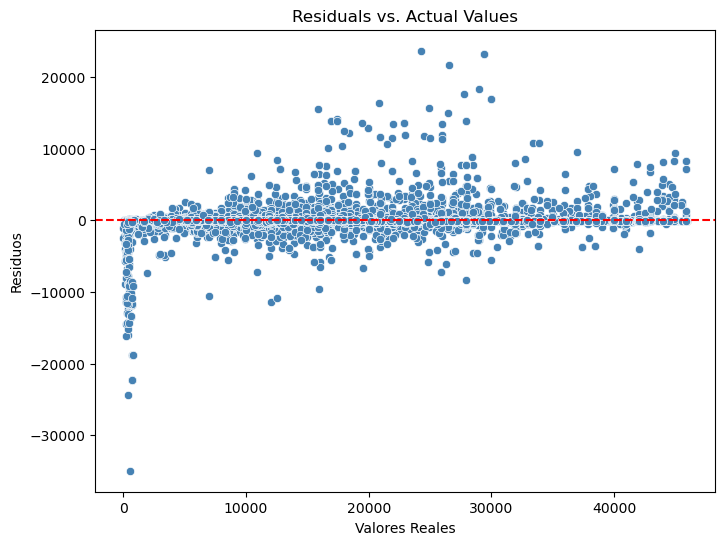

In [40]:
# Residuos
residuals = y_test - y_pred_stacking

# Gráfico Residual vs. Valores Reales
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=residuals, color="steelblue")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Reales')
plt.ylabel('Residuos')
plt.title('Residuals vs. Actual Values')
plt.show()

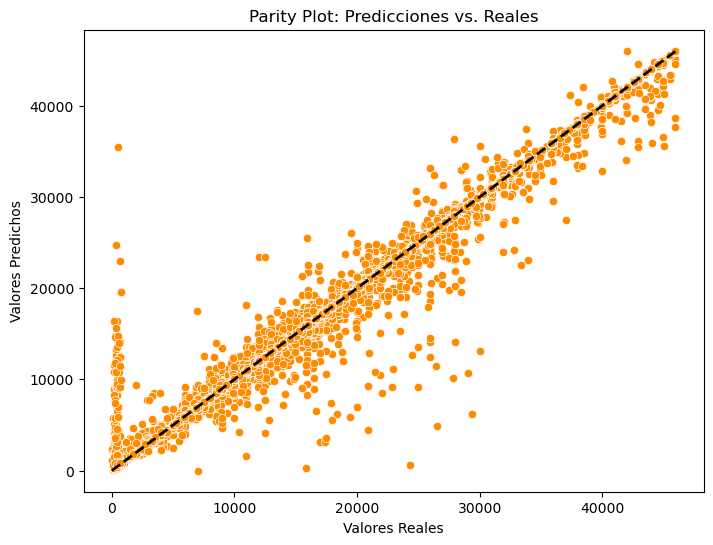

In [41]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_stacking, color="darkorange")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Parity Plot: Predicciones vs. Reales')
plt.show()